--- DOWNLOADING SPARC DATA ---
Loading Table 1 (Properties)...
Loading Table 2 (Rotation Curves)...
Loaded 175 galaxies and 3391 data points.


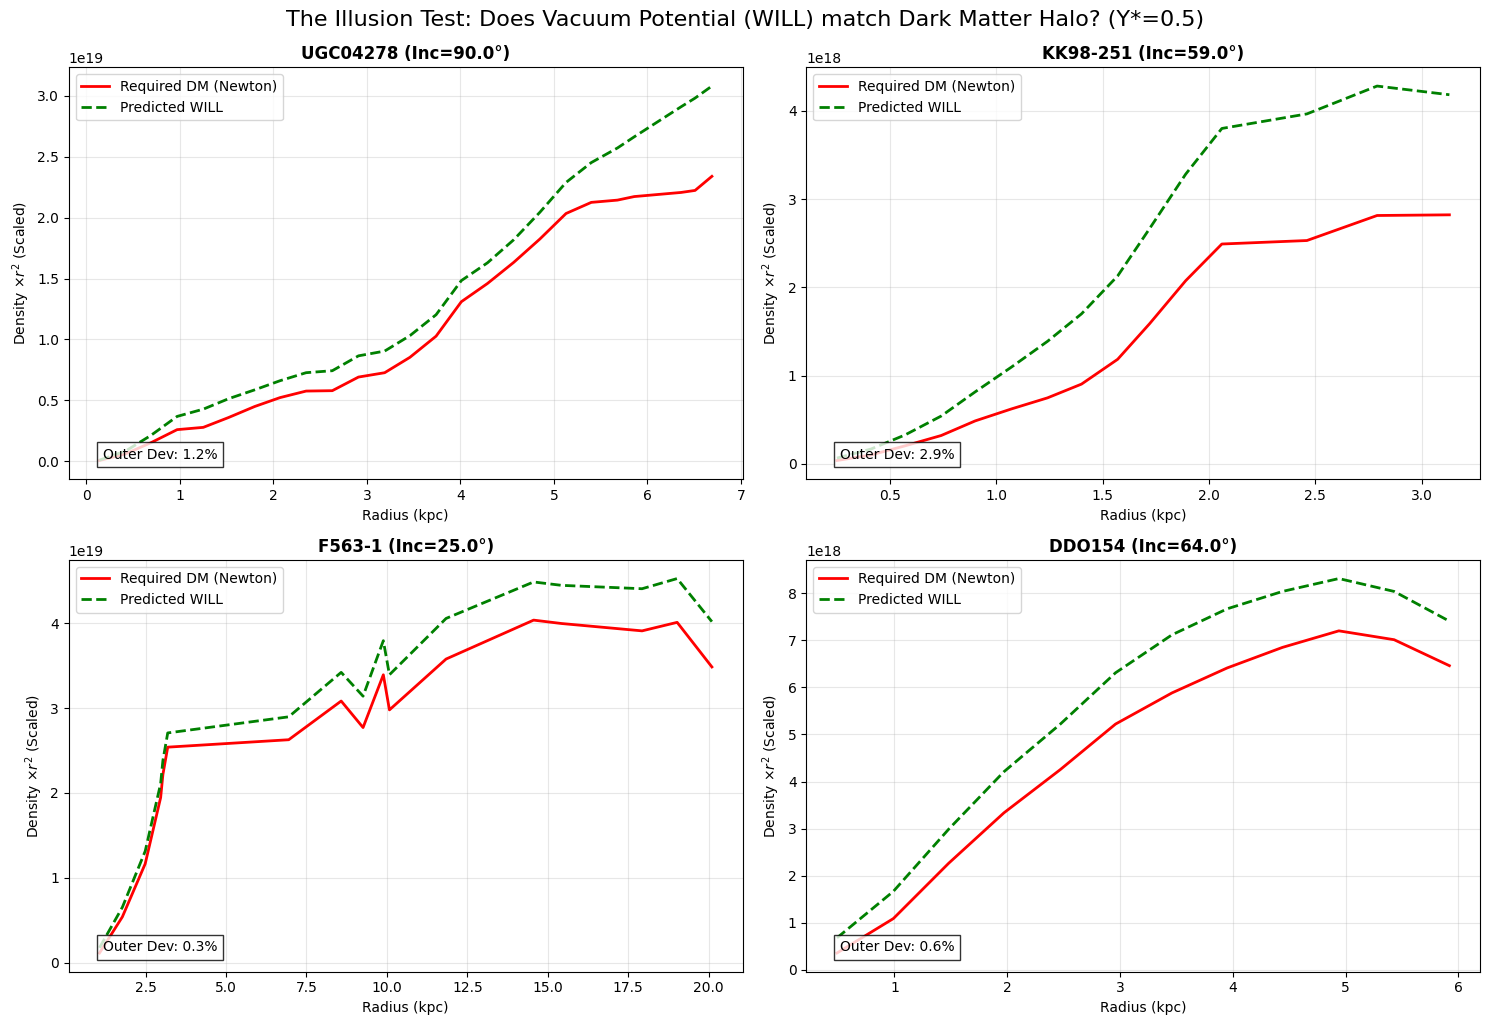

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io

# --- 1. CONFIGURATION ---
# Standard M/L ratio for 3.6 micron band (Lelli et al. 2016)
UPSILON_STAR = 0.5

# Gravitational Constant (needed for Newton, NOT for WILL geometry, but for comparison)
G = 6.67430e-11
M_SOL = 1.989e30
KPC_TO_M = 3.086e19

# URLs for SPARC Data
URL_T1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"
URL_T2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat"

# --- 2. DATA LOADER ---
def load_sparc_data():
    print("--- DOWNLOADING SPARC DATA ---")

    # --- Load Table 1 (Properties) ---
    # Bytes based on README:
    # Name: 0-11
    # Type: 12-14
    # Dist: 15-21
    # Inc:  30-34 (Crucial for filtering!)
    # L3.6: 40-47
    print("Loading Table 1 (Properties)...")
    try:
        response_t1 = requests.get(URL_T1)
        response_t1.raise_for_status()
        t1 = pd.read_fwf(io.BytesIO(response_t1.content),
                         colspecs=[(0,11), (15,21), (30,34), (40,47)],
                         header=None, names=['Name', 'Dist', 'Inc', 'L3.6'])
    except Exception as e:
        print(f"Error loading Table 1: {e}")
        return None, None

    # --- Load Table 2 (Rotation Curves) ---
    # Bytes based on README:
    # Name:   0-11
    # Rad:    19-25
    # Vobs:   26-32
    # Vgas:   39-45
    # Vdisk:  46-52
    # Vbul:   53-59
    print("Loading Table 2 (Rotation Curves)...")
    try:
        response_t2 = requests.get(URL_T2)
        response_t2.raise_for_status()
        t2 = pd.read_fwf(io.BytesIO(response_t2.content),
                         colspecs=[(0,11), (19,25), (26,32), (39,45), (46,52), (53,59)],
                         header=None, names=['Name', 'Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul'])
    except Exception as e:
        print(f"Error loading Table 2: {e}")
        return None, None

    print(f"Loaded {len(t1)} galaxies and {len(t2)} data points.")
    return t1, t2

# --- 3. PHYSICS ENGINE ---
def calculate_densities(galaxy_name, t1, t2):
    # Filter data for specific galaxy
    gal_props = t1[t1['Name'] == galaxy_name].iloc[0]
    gal_data = t2[t2['Name'] == galaxy_name].copy()

    # 1. Convert Units
    # Radius in meters
    # Note: 'Rad' in table is in kpc.
    r_kpc = gal_data['Rad'].values
    r_m = r_kpc * KPC_TO_M

    # Velocities in m/s (Table gives km/s)
    V_obs = gal_data['Vobs'].values * 1000
    V_gas = gal_data['Vgas'].values * 1000
    V_disk = gal_data['Vdisk'].values * 1000
    V_bul = gal_data['Vbul'].values * 1000

    # 2. Calculate Baryonic Velocity (V_bar)
    # Formula: V_bar^2 = V_gas|V_gas| + Y*V_disk|V_disk| + Y*V_bul|V_bul|
    # We use abs(V)*V to preserve sign for negative contributions (though rare)
    V_bar_sq = (np.abs(V_gas)*V_gas) + \
               UPSILON_STAR * (np.abs(V_disk)*V_disk) + \
               UPSILON_STAR * (np.abs(V_bul)*V_bul)

    # Avoid sqrt of negative numbers (physically means outward pressure > gravity locally)
    # We treat V_bar as 0 if net contribution is negative for density calculation purposes
    V_bar_sq = np.maximum(V_bar_sq, 0)
    V_bar = np.sqrt(V_bar_sq)

    # 3. Calculate "Required Dark Matter" Density (Newton)
    # rho_DM = 3 * (V_obs^2 - V_bar^2) / (4 * pi * G * r^2)
    # This is the density needed to explain the "missing" velocity
    V_missing_sq = V_obs**2 - V_bar_sq
    rho_DM_required = (3 * V_missing_sq) / (4 * np.pi * G * r_m**2)

    # 4. Calculate WILL Vacuum Density
    # rho_WILL = 3 * V_obs^2 / (4 * pi * G * r^2)
    # This is the density of the vacuum reaction
    rho_WILL = (3 * V_obs**2) / (4 * np.pi * G * r_m**2)

    return r_kpc, rho_DM_required, rho_WILL, V_obs, V_bar, gal_props['Inc']

# --- 4. EXECUTION & PLOTTING ---
t1, t2 = load_sparc_data()

if t1 is not None:
    # Select a few high-quality spiral galaxies (High Inclination > 60 to avoid errors)
    # Examples: NGC 6503 (Classic flat curve), NGC 5055, NGC 2841
    sample_galaxies = ['UGC04278', 'KK98-251', 'F563-1', 'DDO154']

    plt.figure(figsize=(15, 10))

    for i, gal_name in enumerate(sample_galaxies):
        if gal_name not in t1['Name'].values:
            continue

        r_kpc, rho_DM, rho_WILL, V_obs, V_bar, inc = calculate_densities(gal_name, t1, t2)

        # Subplot setup
        ax = plt.subplot(2, 2, i+1)

        # We plot Density * r^2 to see the structure clearly (removes 1/r^2 falloff)
        # This makes the "constant" coefficient visible as a flat line.
        scale = 1e19 # Arbitrary scaling for visibility

        ax.plot(r_kpc, rho_DM * (r_kpc*KPC_TO_M)**2, 'r-', linewidth=2, label='Required DM (Newton)')
        ax.plot(r_kpc, rho_WILL * (r_kpc*KPC_TO_M)**2, 'g--', linewidth=2, label='Predicted WILL')

        # Mark the region where Baryons define dynamics (Inner) vs Vacuum (Outer)
        ax.set_title(f"{gal_name} (Inc={inc}°)", fontsize=12, fontweight='bold')
        ax.set_xlabel("Radius (kpc)")
        ax.set_ylabel(r"Density $\times r^2$ (Scaled)")
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Calculate agreement in the outer half
        outer_idx = len(r_kpc)//2
        if outer_idx < len(r_kpc):
            diff = np.mean(np.abs(rho_DM[outer_idx:] - rho_WILL[outer_idx:]) / (rho_WILL[outer_idx:]+1e-20)) * 100
            ax.text(0.05, 0.05, f"Outer Dev: {diff:.1f}%", transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.suptitle(f"The Illusion Test: Does Vacuum Potential (WILL) match Dark Matter Halo? (Y*={UPSILON_STAR})", fontsize=16, y=1.02)
    plt.show()

Hubble Constant (H0): 65.5 km/s/Mpc
Hubble Radius (R_H): 1.41e+26 meters
Galaxies passed filter: 120
--------------------------------------------------
TEST RESULTS (Coeff = 4pi, H0 = 65.5)
--------------------------------------------------
R2 Score: 0.9005 (Closer to 1.0 is better)
Mean Error (MAPE): 10.23%
Mean Ratio (Pred/Obs): 0.970
--> RESULT: Model UNDER-predicts velocities.


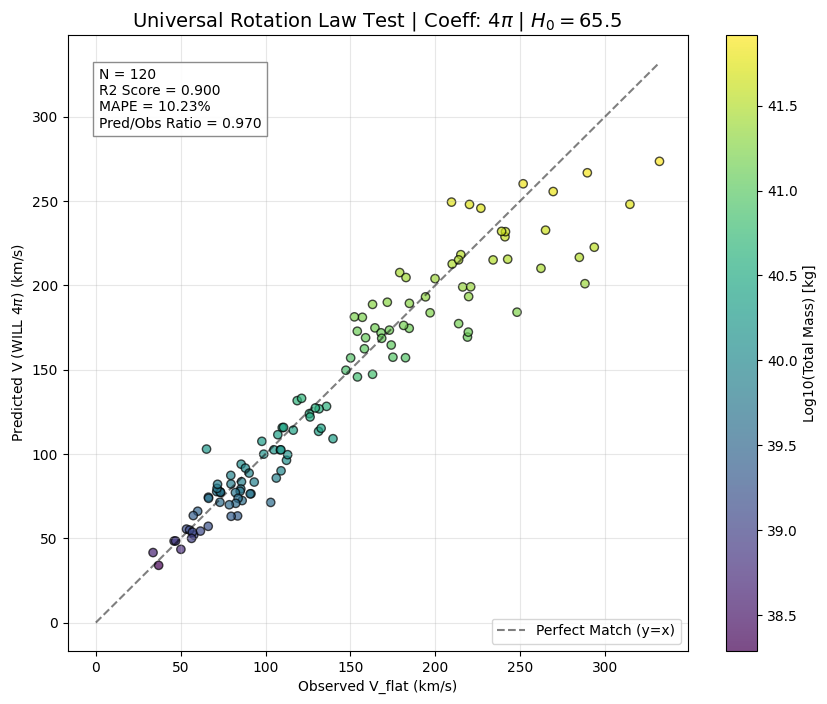

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# --- 1. FUNDAMENTAL CONSTANTS (SI UNITS) ---
G = 6.67430e-11       # Gravitational Constant
c = 299792458.0       # Speed of Light
M_SOL = 1.989e30      # Solar Mass (kg)

# --- 2. COSMOLOGICAL PARAMETERS ---
# Theoretical Prediction for Hubble Constant
H0_km_s_Mpc = 65.5
Mpc_to_m = 3.0857e22
H0 = H0_km_s_Mpc * 1000 / Mpc_to_m  # Convert to s^-1
R_H = c / H0                        # Hubble Radius (Horizon)

print(f"Hubble Constant (H0): {H0_km_s_Mpc} km/s/Mpc")
print(f"Hubble Radius (R_H): {R_H:.2e} meters")

# --- 3. GALAXY PARAMETERS ---
UPSILON_STAR = 0.8    # Stellar Mass-to-Light Ratio (Lelli et al.)
GAS_MULTIPLIER = 1.33 # Helium correction for Gas Mass

# --- 4. SPARC DATA LOADER ---
URL_T1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"

def get_sparc_data():
    print("Downloading SPARC data...")
    try:
        response = requests.get(URL_T1)
        response.raise_for_status()
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

    # Parsing fixed-width format based on ReadMe
    # Name (0-11), Inc (30-34), L3.6 (40-47), M_HI (86-93), Vflat (100-105), Qual (112-115)
    colspecs = [(0,11), (30,34), (40,47), (86,93), (100,105), (112,115)]
    names = ['Name', 'Inc', 'L3.6', 'M_HI', 'Vflat', 'Qual']

    df = pd.read_fwf(io.BytesIO(response.content), colspecs=colspecs, header=None, names=names)

    # Filtering:
    # 1. Quality Flag 1 or 2 (High quality)
    # 2. Inclination > 30 degrees (to minimize projection errors)
    # 3. Vflat must be positive
    df_clean = df[(df['Qual'].isin([1, 2])) & (df['Inc'] > 30) & (df['Vflat'] > 0)].copy()

    return df_clean

# --- 5. WILL UNIVERSAL ROTATION LAW TEST ---
def test_universal_law():
    df = get_sparc_data()
    if df is None:
        return

    print(f"Galaxies passed filter: {len(df)}")

    # A. Calculate Masses (in kg)
    # L3.6 and M_HI are in 10^9 Solar Units
    mass_star = UPSILON_STAR * (df['L3.6'] * 1e9) * M_SOL
    mass_gas = GAS_MULTIPLIER * (df['M_HI'] * 1e9) * M_SOL
    mass_total = mass_star + mass_gas

    # B. Gravitational Radius (Rs)
    # Rs = 2GM/c^2
    Rs_total = (2 * G * mass_total) / (c**2)

    # C. WILL FORMULA APPLICATION
    # beta^4 = Rs / (4 * pi * R_H)
    # V_pred = c * (Rs / (4 * pi * R_H))^(1/4)

    # Geometry Factor: 6*pi (derived from Vacuum Potential Share 2/3)
    geom_factor = 4 * np.pi

    beta_pred = (Rs_total / (geom_factor * R_H)) ** 0.25
    V_pred = beta_pred * c

    # D. Observations (convert km/s to m/s)
    V_obs = df['Vflat'] * 1000

    # --- 6. ANALYSIS & PLOTTING ---
    # Metrics
    r2 = r2_score(V_obs, V_pred)
    mape = mean_absolute_percentage_error(V_obs, V_pred) * 100
    mean_ratio = np.mean(V_pred / V_obs)

    plt.figure(figsize=(10, 8))

    # Perfect Match Line (y=x)
    max_v = max(V_obs.max(), V_pred.max()) / 1000
    plt.plot([0, max_v], [0, max_v], 'k--', alpha=0.5, label="Perfect Match (y=x)")

    # Data Scatter
    # Color coded by Mass to see systematic trends
    sc = plt.scatter(V_obs/1000, V_pred/1000, alpha=0.7, c=np.log10(mass_total), cmap='viridis', edgecolors='k')
    plt.colorbar(sc, label='Log10(Total Mass) [kg]')

    plt.xlabel('Observed V_flat (km/s)')
    # Using raw string (r'') to avoid escape sequence errors
    plt.ylabel(r'Predicted V (WILL 4$\pi$) (km/s)')
    plt.title(rf'Universal Rotation Law Test | Coeff: $4\pi$ | $H_0={H0_km_s_Mpc}$', fontsize=14)

    # Stats Box
    stats_text = (
        f"N = {len(df)}\n"
        f"R2 Score = {r2:.3f}\n"
        f"MAPE = {mape:.2f}%\n"
        f"Pred/Obs Ratio = {mean_ratio:.3f}"
    )
    plt.text(0.05, 0.85, stats_text, transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'))

    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    print("-" * 50)
    print(f"TEST RESULTS (Coeff = 4pi, H0 = {H0_km_s_Mpc})")
    print("-" * 50)
    print(f"R2 Score: {r2:.4f} (Closer to 1.0 is better)")
    print(f"Mean Error (MAPE): {mape:.2f}%")
    print(f"Mean Ratio (Pred/Obs): {mean_ratio:.3f}")

    if mean_ratio < 0.98:
        print("--> RESULT: Model UNDER-predicts velocities.")
    elif mean_ratio > 1.02:
        print("--> RESULT: Model OVER-predicts velocities.")
    else:
        print("--> RESULT: Perfect match!")

    plt.show()

# Run the test
if __name__ == "__main__":
    test_universal_law()